# HR Analytics

## Task 1: Predicting Hiring Decisions for Connected at Youth Impact

----

In [12]:
# import necessary libraries and functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection, linear_model, tree, ensemble
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_curve, roc_auc_score, confusion_matrix, classification_report
import xgboost as xgb

In [13]:
# global file path
path_application = '/Users/michaelfive/Dropbox/R&I/18_Facilitator_Database/02_Data_Analysis/100_HR-Analytics/01_connected_data/application_data/'

# import the cleaned and imputed dataset
dat = pd.read_csv(path_application + 'cleaned/application_all_mi.csv')

In [3]:
# check the dataset
dat

,app_data_source,loc_region,return_to_yp,score_total,dem_gender,dem_age,edu_qual_highest,edu_qual_highest_year,emp_yes,emp_org_type,...,emp_currently,exp_w_child,exp_length_teacher,exp_length_school,exp_length_employee,exp_length_volunteer,interest_w_child,prac_scenario_volunt,prac_scenario_noshow,yi_hired
0,T1 2020,Kgatleng,No,26.50,Female,28,Bachelors Degree,2013,Yes,Education,...,No,Yes,24.0,12.0,24.0,5.0,4,1,Planning together with fellow facilitators,0
1,T1 2020,Chobe,No,25.50,Female,35,Bachelors Degree,2017,Yes,Education,...,No,Yes,39.6,36.0,39.6,12.0,4,1,Planning together with fellow facilitators,0
2,T1 2020,Central,No,24.50,Female,25,Bachelors Degree,2017,Yes,Education,...,No,Yes,19.2,9.0,19.2,24.0,4,1,Planning together with fellow facilitators,0
3,T1 2020,South East,Yes,23.50,Female,29,Bachelors Degree,2013,Yes,Education,...,No,Yes,40.8,29.0,60.0,24.0,4,1,Planning together with fellow facilitators,1
4,T1 2020,North West,No,23.50,Female,32,Bachelors Degree,2011,Yes,Education,...,No,Yes,60.0,60.0,72.0,24.0,4,1,Planning together with fellow facilitators,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1905,T3 2023,North East,No,-186.50,Female,23,Secondary School,2018,No,Other,...,Yes,No,21.6,3.0,2.0,2.0,1,1,Planning together with fellow facilitators,0
1906,T3 2023,South East,No,-188.75,Female,20,Secondary School,2021,No,"Health care, social assistance, nonprofit",...,Yes,No,6.0,13.0,11.0,19.0,1,1,Plan individually,0
1907,T3 2023,Kgatleng,No,-191.00,Female,23,Certificate,2017,No,"Health care, social assistance, nonprofit",...,Yes,No,30.0,24.0,7.0,3.0,1,1,Plan individually,0
1908,T3 2023,North East,No,-192.00,Female,22,Secondary School,2018,No,Other,...,No,No,18.0,24.0,24.0,36.0,1,1,Plan individually,0


In [14]:
# split the data into training and testing sets
X = dat.drop(['yi_hired'], axis=1)
y = dat['yi_hired']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, stratify = y, random_state = 1234)

In [15]:
# summary statistics of the outcome variable
print(y_train.value_counts())
print(y_test.value_counts())

yi_hired
0    1352
1     176
Name: count, dtype: int64
yi_hired
0    338
1     44
Name: count, dtype: int64


# Modeling

## Preprocessing Pipeline

In [16]:
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
print(f'There are {len(numerical_features)} numerical features:', '\n')
print(numerical_features)

There are 10 numerical features: 

['score_total', 'dem_age', 'edu_qual_highest_year', 'emp_duration', 'exp_length_teacher', 'exp_length_school', 'exp_length_employee', 'exp_length_volunteer', 'interest_w_child', 'prac_scenario_volunt']


In [17]:
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()
print(f'There are {len(categorical_features)} categorical features:', '\n')
print(categorical_features)

There are 10 categorical features: 

['app_data_source', 'loc_region', 'return_to_yp', 'dem_gender', 'edu_qual_highest', 'emp_yes', 'emp_org_type', 'emp_currently', 'exp_w_child', 'prac_scenario_noshow']


In [18]:
# Create pipeline for numeric and categorical variables separately
numeric_pipeline = Pipeline(steps=[
    ('scale', MinMaxScaler()) # standardizing
])

categorical_pipeline = Pipeline(steps=[
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # one hot encoding
])

full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features)
])

In [19]:
# function to get the adjusted threshold
def adjust_threshold(model, X_test, y_test):
    # Predict probabilities
    yhat = model.predict_proba(X_test)

    # Retrieve the probabilities for the positive class
    yhat_positive = yhat[:, 1]

    # Calculate inputs for the roc curve
    fpr, tpr, thresholds = roc_curve(y_test, yhat_positive)

    # Get the best threshold
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]

    # Get predicted probabilities based on the best theshold
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Apply the threshold to the probabilities
    y_pred = (y_pred_proba >= best_thresh).astype(int)

    return y_pred

## Logistic Regression

In [10]:
# Pipeline
logistic_pipe = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', linear_model.LogisticRegression(max_iter = 3000, class_weight='balanced'))
])

# Grid search
logistic_search = GridSearchCV(
    logistic_pipe,
    {'model__C':np.logspace(-3,3,7), 
     'model__penalty': ['l2'], 
     'model__solver': ['lbfgs']},
    cv = model_selection.RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1), 
    scoring="balanced_accuracy",
    verbose=False
)

In [11]:
# Train the model using the training sets
logistic_fit = logistic_search.fit(X_train, y_train)

# Make predictions using the testing set
# y_pred_logistic = logistic_fit.predict(X_test)
y_pred_logistic = adjust_threshold(logistic_fit, X_test, y_test)

In [12]:
print(confusion_matrix(y_test, y_pred_logistic))
print(classification_report(y_test, y_pred_logistic))

[[197 141]
 [  7  37]]
              precision    recall  f1-score   support

           0       0.97      0.58      0.73       338
           1       0.21      0.84      0.33        44

    accuracy                           0.61       382
   macro avg       0.59      0.71      0.53       382
weighted avg       0.88      0.61      0.68       382



# Tree model

In [13]:
# Pipeline
tree_pipe = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', tree.DecisionTreeClassifier(random_state = 1234, class_weight='balanced'))
])

# Grid search
tree_search = GridSearchCV(tree_pipe,
                           {'model__max_depth':np.arange(2,12,2)},
                           cv = model_selection.RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1), 
                           scoring="balanced_accuracy",
                           verbose=False
                      )

# Train the model using the training sets
tree_fit = tree_search.fit(X_train, y_train)

In [14]:
# Make predictions using the testing set
# y_pred_tree = tree_search.predict(X_test)
y_pred_tree = adjust_threshold(tree_fit, X_test, y_test)

In [15]:
print(confusion_matrix(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

[[194 144]
 [  8  36]]
              precision    recall  f1-score   support

           0       0.96      0.57      0.72       338
           1       0.20      0.82      0.32        44

    accuracy                           0.60       382
   macro avg       0.58      0.70      0.52       382
weighted avg       0.87      0.60      0.67       382



In [16]:
# plot tree results (if needed)

# plt.figure(figsize=(30, 15)) # Resize figure
           
# tree.plot_tree(tree_search.best_estimator_["model"],               
#               fontsize = 20)

# Random Forest

In [17]:
# Pipeline
rf_pipe = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', ensemble.RandomForestClassifier(random_state = 1234, class_weight='balanced'))
])

# A full grid search takes way too long to run, so I am using randomized search CV here.
rf_search = RandomizedSearchCV(rf_pipe,
                               {'model__n_estimators': [20,50,100],
                                'model__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                                'model__max_features': ['sqrt'],
                                'model__min_samples_leaf': [1, 2, 4],
                                'model__min_samples_split': [2, 5, 10],
                                'model__bootstrap': [True, False]
                                },
                               cv = model_selection.RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1),
                               scoring="balanced_accuracy",
                               verbose=True)

# Train the model using the training sets
rf_fit = rf_search.fit(X_train, y_train)

Fitting 30 folds for each of 10 candidates, totalling 300 fits


In [18]:
# Make predictions using the testing set
# y_pred_rf = rf_search.predict(X_test)
y_pred_rf = adjust_threshold(rf_fit, X_test, y_test)

In [19]:
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

[[294  44]
 [ 15  29]]
              precision    recall  f1-score   support

           0       0.95      0.87      0.91       338
           1       0.40      0.66      0.50        44

    accuracy                           0.85       382
   macro avg       0.67      0.76      0.70       382
weighted avg       0.89      0.85      0.86       382



# XG Boost

In [35]:
# calculate the scale_pos_weight value
class_counts = y_train.value_counts()
scale_pos_weight = class_counts[0] / class_counts[1]

# Pipeline
xgb_pipe = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', xgb.XGBClassifier(random_state = 1234, 
                                eval_metric='logloss', 
                                scale_pos_weight = scale_pos_weight))
])

# Parameter grid for XGBoost
param_grid = {'model__n_estimators': [20,50,100],
              'model__learning_rate': [0.01, 0.1, 0.2, 0.3],
              'model__max_depth': [3, 5, 7, 10],
              'model__colsample_bytree': [0.5, 0.7, 1],
              'model__gamma': [0, 0.1, 0.2]}

# Use randomized search CV here
xgb_search = RandomizedSearchCV(xgb_pipe,
                                param_grid,
                                cv = model_selection.RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1),
                                scoring="balanced_accuracy",
                                verbose=True)

# Train the model using the training sets
xgb_fit = xgb_search.fit(X_train, y_train)

Fitting 30 folds for each of 10 candidates, totalling 300 fits


In [50]:
# Make predictions using the testing set
# y_pred_xgb = xgb_search.predict(X_test)
y_pred_xgb = adjust_threshold(xgb_fit, X_test, y_test)

In [51]:
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

[[209 129]
 [  5  39]]
              precision    recall  f1-score   support

           0       0.98      0.62      0.76       338
           1       0.23      0.89      0.37        44

    accuracy                           0.65       382
   macro avg       0.60      0.75      0.56       382
weighted avg       0.89      0.65      0.71       382



# Interpreting the best model (XGBoost)

## Class 0 (Not Hired)
- Precision: 0.98 indicates that when the model predicts class 0, it's correct 98% of the time. In other words, if the model predicts "Not Hired," it's very likely to be correct.
- Recall: 0.62 means that the model correctly identifies 62% of all actual class 0 instances in the dataset. This implies that it's missing a significant portion (38%) of the "Not Hired" cases, potentially classifying them as "Hired."
- F1-Score: 0.76 is the harmonic mean of precision and recall. It gives a single metric that balances the trade-off between precision and recall. The high precision but lower recall for class 0 results in this intermediate f1-score.
- Support: 338 is the total number of actual instances of class 0 in the data.

## Class 1 (Hired)
- Precision: 0.23 indicates that when the model predicts class 1, it's correct only 23% of the time. This means that many of the "Hired" predictions are false positives.
- Recall: 0.89 means that the model correctly identifies 89% of all actual class 1 instances in the dataset. Despite the low precision, the model is quite good at capturing the majority of the "Hired" cases.
- F1-Score: 0.37 is the harmonic mean of precision and recall for class 1. This low value reflects the model's struggle to balance high recall with low precision for class 1.
- Support: 44 is the total number of actual instances of class 1 in the data. 

**Recall-oriented hiring strategy: If we are more focused on not missing any potentially qualified candidates (true positives), then we would prioritize recall. This strategy makes sense when the cost of missing a good candidate (false negative) is high. For example, in a highly competitive job market, or for positions that require unique skills, we might prefer to have a larger candidate pool to ensure we don't overlook someone who could be a great fit.**

## Variable Importance Plot

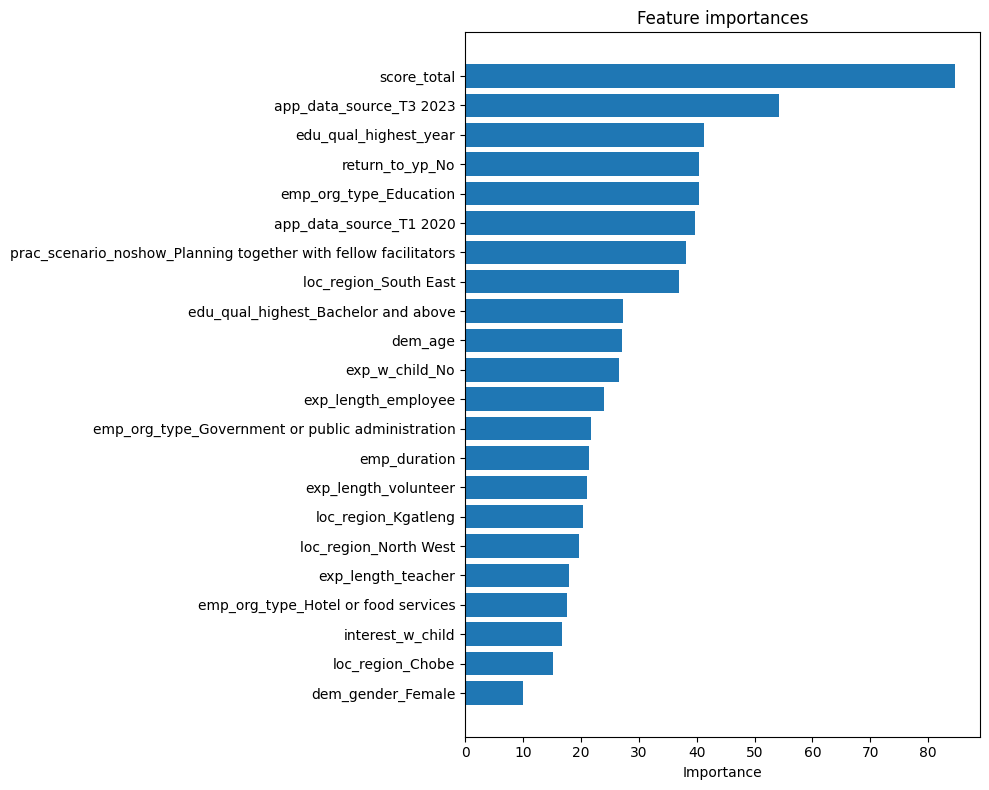

In [33]:
# Additional code for feature importances
# Extract the best estimator
best_model = xgb_fit.best_estimator_.named_steps['model']

# Get feature importance
importance = best_model.get_booster().get_score(importance_type='gain')

# Get feature names after transformation
# For numeric features, the names stay the same
numeric_feature_names = numerical_features

# For categorical features, get out the one-hot encoded column names
ohe = xgb_fit.best_estimator_.named_steps['preprocess'].named_transformers_['category'].named_steps['one-hot']
categorical_feature_names = ohe.get_feature_names_out(categorical_features)

# Combine the two lists
feature_names = np.concatenate([numeric_feature_names, categorical_feature_names])

# Now you can create the fmap using these feature names
fmap = {f'f{i}': col for i, col in enumerate(feature_names)}

# Replace feature names in the importance dict
importance = {fmap[k]: v for k, v in importance.items()}

# Convert the importance to a DataFrame for easier plotting
importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10,8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()  # Invert y-axis to place the most important features at the top
plt.xlabel('Importance')
plt.title('Feature importances')
plt.tight_layout()
plt.savefig('feature_importances_hiring.png')
plt.show()


# Save model objects for future use

In [40]:
# Import the base class for scikit-learn estimators to check the types of your objects
from sklearn.base import BaseEstimator

# Get a dictionary of all global objects
global_objects = globals()

# Filter this dictionary to get only the model objects
model_objects = {name: obj for name, obj in global_objects.items() if isinstance(obj, BaseEstimator)}

# Print the names of the model objects
for name in model_objects.keys():
    print(name)


numeric_pipeline
categorical_pipeline
full_processor
logistic_pipe
logistic_search
logistic_fit
tree_pipe
tree_search
tree_fit
rf_pipe
rf_search
rf_fit
xgb_pipe
xgb_search
xgb_fit
best_model
ohe


In [56]:
import joblib
import os

# Create a designated folder
os.makedirs('/Users/michaelfive/Desktop/R Directory/Youth Impact/yp_hr_analytics/models', exist_ok=True)

# Create a dictionary that contains all your objects
saved_objects = {
    'numeric_pipeline': numeric_pipeline,
    'categorical_pipeline': categorical_pipeline,
    'full_processor': full_processor,
    'xgb_pipe': xgb_pipe,
    'xgb_search': xgb_search,
    'xgb_fit': xgb_fit,
    'logistic_pipe': logistic_pipe,
    'logistic_search': logistic_search,
    'logistic_fit': logistic_fit,
    'tree_pipe': tree_pipe,
    'tree_search': tree_search,
    'tree_fit': tree_fit,
    'rf_pipe': rf_pipe,
    'rf_search': rf_search,
    'rf_fit': rf_fit,
}

# Save the dictionary containing all objects
joblib.dump(saved_objects, '/Users/michaelfive/Desktop/R Directory/Youth Impact/yp_hr_analytics/models/ML_models_predict_hiring.pkl')

# Save the best model (xgboost)
joblib.dump(xgb_fit, '/Users/michaelfive/Desktop/R Directory/Youth Impact/yp_hr_analytics/models/xgb_fit.pkl')

['/Users/michaelfive/Desktop/R Directory/Youth Impact/yp_hr_analytics/models/xgb_fit.pkl']

# Predict future hiring

In [231]:
# Store possible values of string variables into a dictionary of lists
# choices = {f"choices_{col}": dat[col].unique().tolist() for col in dat.columns if dat[col].dtype == 'object'}
# choices

In [57]:
# Manually specific a new data frame with one new entry of data
temp_vars = {
    'app_data_source': "T2 2022",
    'loc_region': 'South East',
    'return_to_yp': 'Yes',
    'score_total': 27,
    'dem_gender': 'Female',
    'dem_age': 25,
    'edu_qual_highest': 'Bachelor and above',
    'edu_qual_highest_year': 2020,
    'emp_yes': 'Yes',
    'emp_org_type': 'Health care, social assistance, nonprofit',
    'emp_duration': 45.6,
    'emp_currently': 'No',
    'exp_w_child': 'Yes',
    'exp_length_teacher': 9.0,
    'exp_length_school': 16.8,
    'exp_length_employee': 12.0,
    'exp_length_volunteer': 6.0,
    'interest_w_child': 4,
    'prac_scenario_volunt': 1,
    'prac_scenario_noshow': 'Planning together with fellow facilitators'
}

temp_df = pd.DataFrame([temp_vars])


In [58]:
# Retrieve the best estimator from the RandomizedSearchCV
best_model = xgb_fit.best_estimator_

# Extract the preprocessor from the best estimator
preprocessor = best_model.named_steps['preprocess']

# Preprocess the single row using the fitted preprocessor
preprocessed_row = preprocessor.transform(temp_df)

# Get the predicted probabilities for the preprocessed row
predicted_probabilities = best_model.named_steps['model'].predict_proba(preprocessed_row)

# Extract the probability for class 1 (hired)
probability_hired = predicted_probabilities[0][1]  # The second value in the array

# Predict the hiring probabilities for this new potential hire
print(f"Predicted likelihood of being hired: {probability_hired * 100:.2f}%")

Predicted likelihood of being hired: 81.74%


**For an easier use of the model, see the python shiny website.**